## Week 3: Histopathalogic Cancer Detection


## 1. Abstract

The goal of this project is to develop an algorithm capable of detecting metastatic cancer from small image patches extracted from larger whole-slide pathology scans. The dataset used in this competition is a slightly modified version of the PatchCamelyon (PCam) dataset, which provides a benchmark for binary classification in the context of cancer detection. Unlike the original PCam dataset, which includes duplicate images due to probabilistic sampling, the Kaggle version has been adjusted to exclude these duplicates.

PatchCamelyon consists of 327,680 color images (96x96 pixels) extracted from lymph node tissue pathology scans, each labeled with a binary tag indicating the presence or absence of metastatic tissue. The dataset is designed to be clinically relevant while offering a straightforward binary classification problem, making it an ideal starting point for machine learning models focused on cancer detection.

We will employ Convolutional Neural Networks (CNNs) to classify these small image patches and determine the presence of metastatic cancer. The PCam dataset is particularly appealing due to its manageable size, ease of use, and the balance it strikes between task difficulty and tractability, which makes it a suitable benchmark for research in active learning, model uncertainty, and interpretability. This project will demonstrate how CNNs can be applied to clinical image data, providing insights into early detection and assisting healthcare professionals in diagnosing metastatic cancer.

## 2. Data

## 2.1 Load Data

In [1]:
import os
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import scipy

In [3]:
#Loading the train and test datasets.
train_dir = "train"
test_dir = "test"

In [6]:
# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for image in os.listdir(directory):
        image_path = os.path.join(directory, image)
        with Image.open(image_path) as temp_image: 
            temp_image_array = np.array(temp_image)
        images.append(temp_image_array)
    return images

# Load images
train_images = load_images_from_directory(train_dir)
test_images = load_images_from_directory(test_dir)

# Print the number of images
print("Images in train data:", len(train_images))
print("Images in test data:", len(test_images))

Images in train data: 220025
Images in test data: 57458


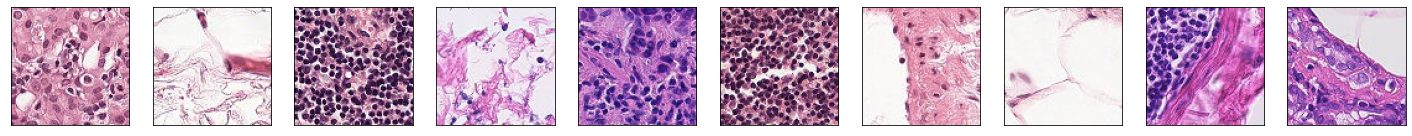

In [5]:
def display_images_from_directory(directory, num_images=10):
    fig = plt.figure(figsize=(25, 4))  
    for i in range(num_images):
        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        
        # Build the image path and open the image
        image_path = os.path.join(directory, os.listdir(directory)[i])
        with Image.open(image_path) as im:  # Use 'with' to auto-close the image
            ax.imshow(im)  
    
    plt.show()
display_images_from_directory(train_dir)

In [4]:
train_labels = pd.read_csv("./train_labels.csv")
sample = pd.read_csv("./sample_submission.csv")
train_labels['path'] = "./train/"+train_labels['id']+".tif"
train_labels['label'] = train_labels['label'].astype(str)
#The labels for the ten example images above.
for i in range(10):
    print(train_labels[train_labels['id']+".tif" == os.listdir(train_dir)[i]]['label'])

151577    1
Name: label, dtype: object
16166    0
Name: label, dtype: object
87832    0
Name: label, dtype: object
69359    0
Name: label, dtype: object
128953    1
Name: label, dtype: object
95060    0
Name: label, dtype: object
134354    0
Name: label, dtype: object
52564    0
Name: label, dtype: object
78234    0
Name: label, dtype: object
90027    1
Name: label, dtype: object


### 2.2 Exploratory Data Analysis (EDA)

In [6]:
#Exploring the distribution of labels in the training dataset.
train_labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [7]:
train_labels.describe()

,id,label,path
count,220025,220025,220025
unique,220025,2,220025
top,f38a6374c348f90b587e046aac6079959adf3835,0,./train/f38a6374c348f90b587e046aac6079959adf38...
freq,1,130908,1


In [ ]:
import seaborn as sns
train_labels_viz = train_labels.copy()
train_labels_viz['label'] = train_labels_viz['label'].astype(int)
# Use a stacked bar chart to display the label distribution
sns.countplot(x='label', data=train_labels_viz, palette='Set2')
plt.title('Label Distribution')
plt.xlabel('Cancerous vs Non-Cancerous')
plt.ylabel('Count')
plt.show()

# Use pie charts to show the scale of labels
label_counts = train_labels_viz['label'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(label_counts, labels=['Non-Cancerous', 'Cancerous'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title('Label Distribution Pie Chart')
plt.show()


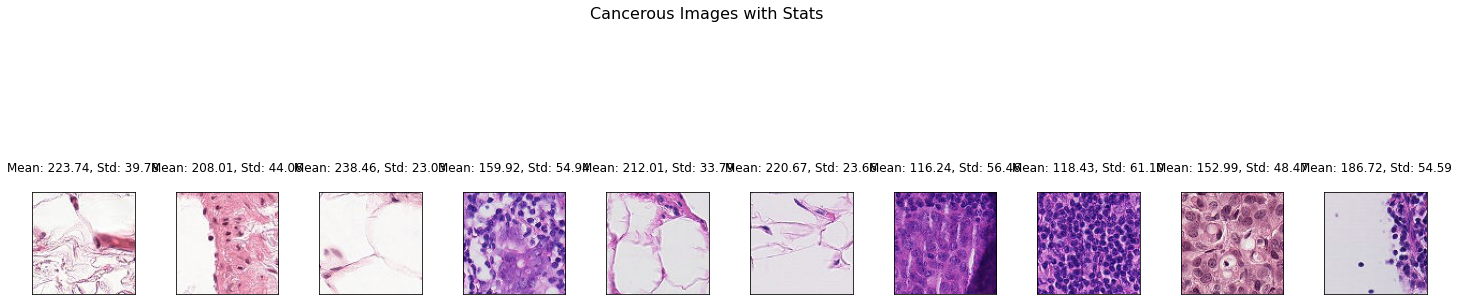

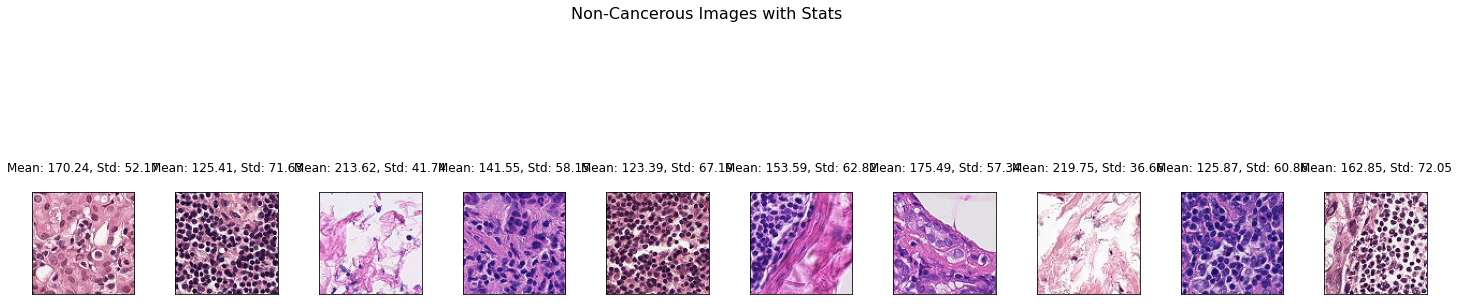

In [9]:
import numpy as np
from PIL import Image
import os

# Prepare labels for visualization
train_labels_viz = train_labels.copy()
train_labels_viz['label'] = train_labels_viz['label'].astype(int)

# Function to display images with their statistics
def display_images_with_stats(labels_df, target_label, num_images=10, row_label="Cancerous", fig_size=(25, 6)):
    fig = plt.figure(figsize=fig_size)  # Increase the figure size
    i, count = 0, 0
    while count < num_images:
        if labels_df.iloc[i, 1] == target_label:
            ax = fig.add_subplot(1, num_images, count + 1, xticks=[], yticks=[])
            image_path = os.path.join(train_dir, os.listdir(train_dir)[i])
            with Image.open(image_path) as im:
                ax.imshow(im)
            
            # Calculate image mean and std
            img_array = np.array(im)
            mean_pixel = np.mean(img_array)
            std_pixel = np.std(img_array)
            
            # Display stats on the image
            ax.set_title(f"Mean: {mean_pixel:.2f}, Std: {std_pixel:.2f}", pad=20)  # Adjust pad for title spacing
            
            count += 1
        i += 1
    plt.suptitle(f"{row_label} Images with Stats", fontsize=16, y=1.05)  # Increase figure title size and adjust y position

    # Adjust spacing between subplots (horizontal)
    plt.subplots_adjust(wspace=0.4)  # Increase space between subplots (horizontal)
    plt.show()

# Display Cancerous Images with stats
display_images_with_stats(train_labels_viz, target_label=1, row_label="Cancerous")

# Display Non-Cancerous Images with stats
display_images_with_stats(train_labels_viz, target_label=0, row_label="Non-Cancerous")


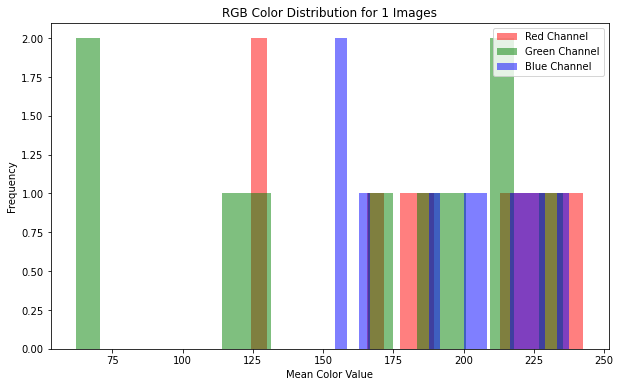

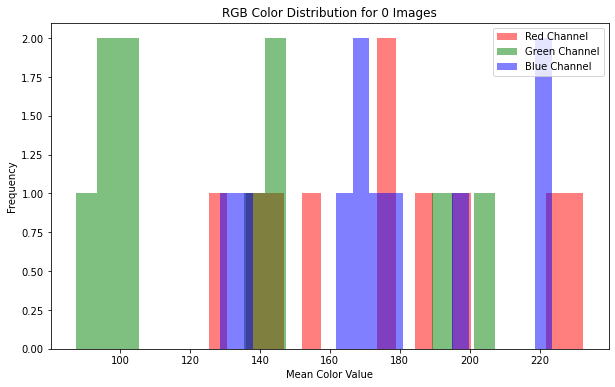

In [10]:
def plot_color_distribution(labels_df, train_dir, target_label, num_images=10):
    reds, greens, blues = [], [], []
    i, count = 0, 0
    while count < num_images:
        if labels_df.iloc[i, 1] == target_label:
            image_path = os.path.join(train_dir, os.listdir(train_dir)[i])
            with Image.open(image_path) as im:
                img_array = np.array(im)
                reds.append(np.mean(img_array[:,:,0]))
                greens.append(np.mean(img_array[:,:,1]))
                blues.append(np.mean(img_array[:,:,2]))
            count += 1
        i += 1
    
    plt.figure(figsize=(10, 6))
    plt.hist(reds, bins=20, alpha=0.5, label='Red Channel', color='r')
    plt.hist(greens, bins=20, alpha=0.5, label='Green Channel', color='g')
    plt.hist(blues, bins=20, alpha=0.5, label='Blue Channel', color='b')
    plt.title(f'RGB Color Distribution for {target_label} Images')
    plt.xlabel('Mean Color Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.show()

# visualize RGB channels for Cancer image
plot_color_distribution(train_labels_viz, train_dir, target_label=1, num_images=10)

# visualize RGB channels for Non-Cancer image
plot_color_distribution(train_labels_viz, train_dir, target_label=0, num_images=10)


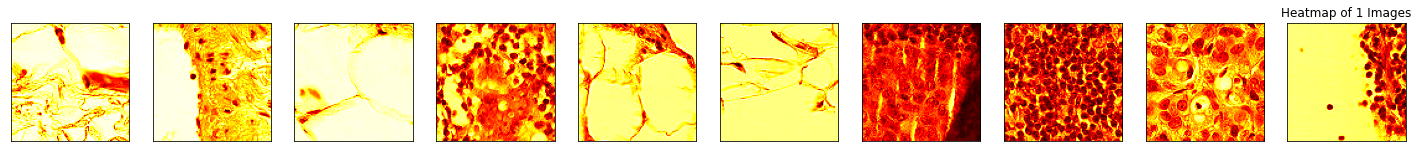

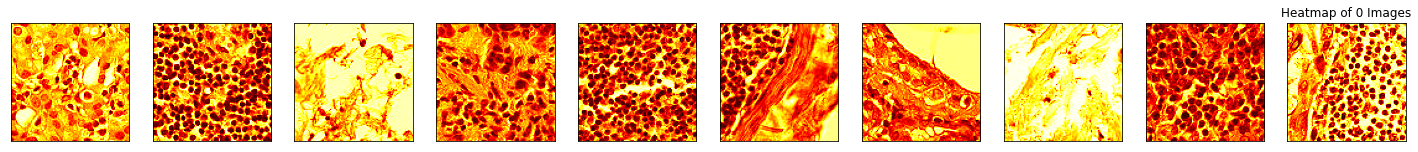

In [11]:
def display_heatmap_of_image(labels_df, train_dir, target_label, num_images=10):
    fig = plt.figure(figsize=(25, 4))
    i, count = 0, 0
    while count < num_images:
        if labels_df.iloc[i, 1] == target_label:
            ax = fig.add_subplot(1, num_images, count + 1, xticks=[], yticks=[])
            image_path = os.path.join(train_dir, os.listdir(train_dir)[i])
            with Image.open(image_path) as im:
                img_array = np.array(im.convert('L'))  # Convert to grayscale
                ax.imshow(img_array, cmap='hot')
            count += 1
        i += 1
    plt.title(f"Heatmap of {target_label} Images")
    plt.show()

# Call this function to display heatmaps for Cancerous images
display_heatmap_of_image(train_labels_viz, train_dir, target_label=1, num_images=10)

# Call this function to display heatmaps for Non-Cancerous images
display_heatmap_of_image(train_labels_viz, train_dir, target_label=0, num_images=10)


Based on the visualization of the images, no significant differences can be observed between positive and negative samples. Therefore, traditional machine learning methods are not highly feasible for this task. To address this issue, we propose leveraging the deep learning framework CNN. The advantage of CNN lies in its powerful adaptability and ability to learn from large amounts of data. By utilizing multiple convolutional layers, CNN can gradually extract features at different levels of abstraction, capturing the subtle differences between positive and negative sample images.

## 3. Model

We had a reduced training set containing 80% of the original training images and a validation set containing 20% of the original training images. To ensure consistency in class distribution between the training and validation data, we used stratified splitting. This method ensures that the class distribution in both the training and validation sets is the same as in the original dataset, thus avoiding class imbalance. Class balance is crucial for machine learning model training, especially when dealing with datasets that have imbalanced class distributions, as it helps prevent the model from being biased towards a particular class.

The purpose of stratified splitting is to ensure that both the training and validation sets are exposed to a representative sample of each class, enabling the model to learn from a balanced range of data. This helps improve the model's generalization ability, prevents overfitting to one class, and enhances the model’s ability to recognize minority classes.

In the following section, we will further verify that the class distribution in both the training and validation sets remains consistent and that no class bias has been introduced during the splitting process. This verification step is crucial for ensuring the accuracy of the data preparation process.

In [7]:
# data split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, 
    train_labels, 
    test_size=0.3, 
    stratify=train_labels['label'],
    random_state=42
)

In [9]:
# Initialize ImageDataGenerator and data augmentation
datagenerator = ImageDataGenerator(
    rescale=1./255,        # Normaliz
    rotation_range=20,     # Random rotation
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2,# Vertical shift
    shear_range=0.2,      
    zoom_range=0.2,      
    horizontal_flip=True,  
    validation_split=0.3,  
    fill_mode='nearest'      
)

# Create training data generator
train_generator = datagenerator.flow_from_dataframe(
    dataframe=y_train,              
    x_col="path",                  
    y_col="label",                  
    target_size=(96, 96),         
    color_mode="rgb",        
    batch_size=32,         
    class_mode="binary",          
    shuffle=True,               
    subset=None,               
    validate_filenames=False
)

# Create validation data generator
validation_generator = datagenerator.flow_from_dataframe(
    dataframe=y_val,                
    x_col="path",             
    y_col="label",           
    target_size=(96, 96),      
    color_mode="rgb",              
    batch_size=32,                
    class_mode="binary",         
    shuffle=False,               
    subset=None,                  
    validate_filenames=False
)

# Create tes data generator
test_files = os.listdir("test")
ids = [file[:-4] for file in test_files]  
files = [os.path.join(test_dir, file) for file in test_files]

test_dataframe = pd.DataFrame({
    'id': ids,
    'file': files
})

# Create test data generator
test_datagenerator = ImageDataGenerator(rescale=1./255)
test_generator = test_datagenerator.flow_from_dataframe(
    dataframe=test_dataframe,     
    x_col='file',                  
    y_col=None,                   
    target_size=(96, 96),
    color_mode="rgb",                
    batch_size=32,               
    shuffle=False,                  
    class_mode=None,             
    validate_filenames=False
)

Found 154017 non-validated image filenames belonging to 2 classes.
Found 66008 non-validated image filenames belonging to 2 classes.
Found 57458 non-validated image filenames.


### 3.1 Common CNN

In [10]:
print(train_labels_viz.columns)

Index(['id', 'label', 'path'], dtype='object')


Training set class balance:
label
0    0.594967
1    0.405033
Name: proportion, dtype: float64

Validation set class balance:
label
0    0.594973
1    0.405027
Name: proportion, dtype: float64

Found 154017 non-validated image filenames belonging to 2 classes.
Found 66008 non-validated image filenames belonging to 2 classes.

test
Found 57458 non-validated image filenames.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_poo

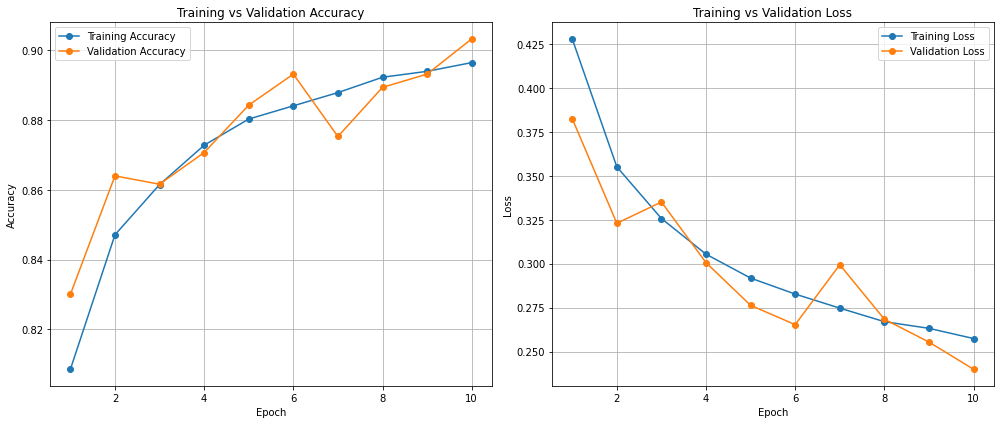

1796/1796 [==============================] - 39s 22ms/step
Test set predictions saved to 'test_predictions.csv'.


In [20]:
# Define CNN
cnn_model = models.Sequential()

# 1 block
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# 2 block
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# 3 block
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# 4 block
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
cnn_model.add(layers.Flatten())

# Fully connected layer
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dropout(0.5))  # Prevent overfitting

# Output layer
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# summary
cnn_model.summary()

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=10,  # You can adjust the number of epochs as needed
    validation_data=validation_generator
)

# Save the model
cnn_model.save('cnn_model.h5')
print("Model saved as 'cnn_model.h5'.")

# Plot accuracy and loss during training
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

# Create a DataFrame with predictions
results = pd.DataFrame({
    'id': test_dataframe['id'],
    'label': predicted_labels
})

# Save the predictions to a CSV file
results.to_csv('test_predictions.csv', index=False)
print("Test set predictions saved to 'test_predictions.csv'.")

### 3.2 More Complex CNN

This enhanced CNN model makes several upgrades in both its architecture and optimization. First, it add batch normalization after each convolution layer, which help stabilize and speed up training. It also change from normal ReLU to LeakyReLU, in order to avoid the "dying neuron" problem and make the model converge easier. Next, it put dropout after each convolution block, so that it can prevent overfitting across the network. Instead of using a simple Flatten, it adopt GlobalAveragePooling2D to average features globally, making the model smaller and generalize better. Also, unlike the old Sequential way, this model use the Functional API, giving more flexibility and easier to expand. In general, it achieve a more stable training and stronger feature extraction while reducing the risk of overfitting.

Training set class balance:
label
0    0.594967
1    0.405033
Name: proportion, dtype: float64

Validation set class balance:
label
0    0.594973
1    0.405027
Name: proportion, dtype: float64
Found 154017 validated image filenames belonging to 2 classes.
Found 66008 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_27 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (No

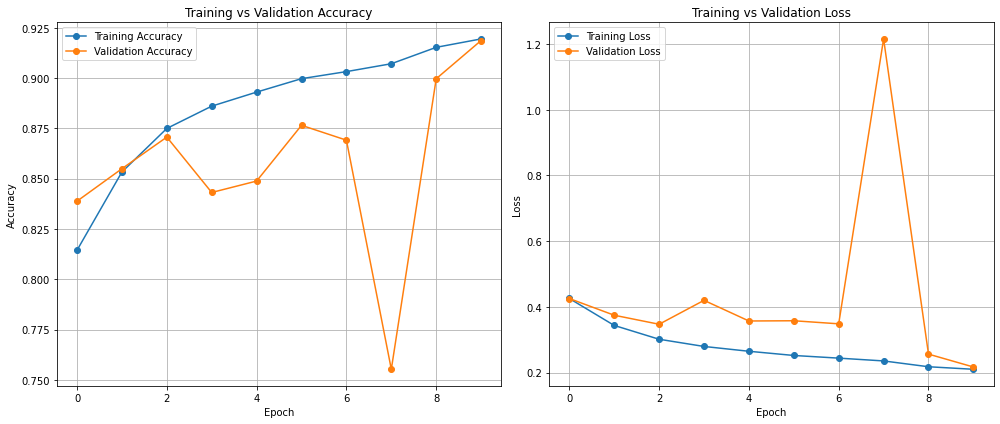

1796/1796 [==============================] - 39s 22ms/step
Test set predictions saved to 'test_predictions.csv'.


In [10]:
# Initialize a much more complex cnn model
Enhanced_cnn = models.Sequential()

# 1 Block
enhanced_cnn_model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(96, 96, 3)))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.Conv2D(32, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
enhanced_cnn_model.add(layers.Dropout(0.25))

# 2 Block
enhanced_cnn_model.add(layers.Conv2D(64, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.Conv2D(64, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
enhanced_cnn_model.add(layers.Dropout(0.25))

# 3 Block
enhanced_cnn_model.add(layers.Conv2D(128, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.Conv2D(128, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
enhanced_cnn_model.add(layers.Dropout(0.25))

# 4 Block
enhanced_cnn_model.add(layers.Conv2D(256, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.Conv2D(256, (3, 3), padding='same'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
enhanced_cnn_model.add(layers.Dropout(0.25))

# Global Average Pooling
enhanced_cnn_model.add(layers.GlobalAveragePooling2D())

# Fully Connected Layers
enhanced_cnn_model.add(layers.Dense(512, activation='relu'))
enhanced_cnn_model.add(layers.BatchNormalization())
enhanced_cnn_model.add(layers.Dropout(0.5))

# Output Layer
enhanced_cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling
enhanced_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for stability
    loss='binary_crossentropy',                       # Binary classification loss
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Evaluation metrics
)

#summary
enhanced_cnn_model.summary()

# Define callbacks for learning rate
lr_reduction = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,            
    patience=5,              
    min_lr=1e-6,             
    verbose=1                 
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',       
    patience=10,             
    restore_best_weights=True,
    verbose=1           
)
# Train
history = enhanced_cnn_model.fit(
    train_generator,
    epochs=10,                       
    validation_data=validation_generator,
    callbacks=[lr_reduction, early_stopping]
)

# Save the trained model
enhanced_cnn_model.save('enhanced_cnn_model.h5')
print("Model saved as 'enhanced_cnn_model.h5'.")

# Plot
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Make predictions on the test set
predictions = enhanced_cnn_model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)

# Create a DataFrame with predictions
results = pd.DataFrame({
    'id': test_dataframe['id'],
    'label': predicted_labels
})

# Save the predictions to a CSV file
results.to_csv('test_predictions.csv', index=False)
print("Test set predictions saved to 'test_predictions.csv'.")


### 3.3 CNN Model (Average pooling)

In this section, we replace the max pooling layers of the CNN (Max pooling) from Section 3.2 with average pooling layers.

Training set class balance:
label
0    0.594967
1    0.405033
Name: proportion, dtype: float64

Validation set class balance:
label
0    0.594973
1    0.405027
Name: proportion, dtype: float64
Found 154017 validated image filenames belonging to 2 classes.
Found 66008 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_45 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_45 (Conv2D)        

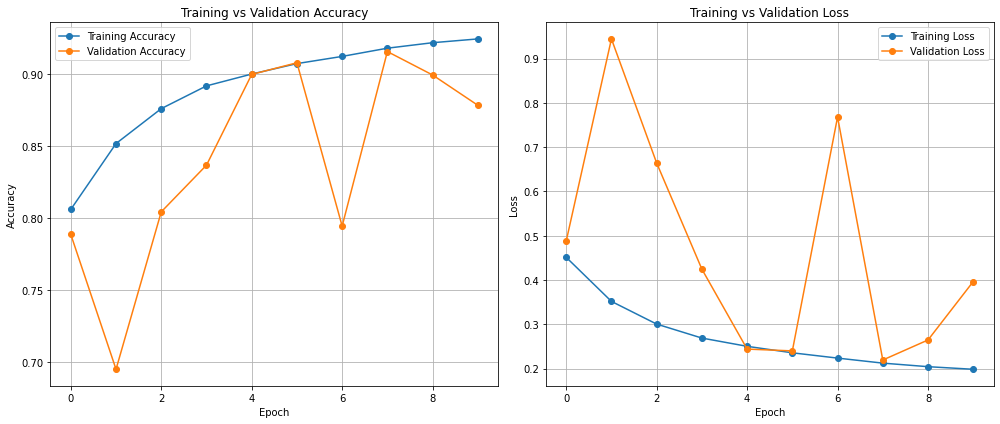

1796/1796 [==============================] - 38s 21ms/step
Test set predictions saved to 'test_predictions.csv'.


In [17]:
# Initialize a new cnn model
enhanced_cnn_model = models.Sequential()

# 1 block
ap_enhanced_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 3)))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
ap_enhanced_cnn_model.add(layers.Dropout(0.25))

# 2 block
ap_enhanced_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.AveragePooling2D((2, 2)))  # Added Average Pooling
ap_enhanced_cnn_model.add(layers.Dropout(0.25))

# 3 block
ap_enhanced_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.MaxPooling2D((2, 2)))
ap_enhanced_cnn_model.add(layers.Dropout(0.25))

# 4 block
ap_enhanced_cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.LeakyReLU(alpha=0.1))
ap_enhanced_cnn_model.add(layers.AveragePooling2D((2, 2)))  # Added Average Pooling
ap_enhanced_cnn_model.add(layers.Dropout(0.25))

# Flatten layer
ap_enhanced_cnn_model.add(layers.Flatten())

# Fully connected layer
ap_enhanced_cnn_model.add(layers.Dense(512, activation='relu'))
ap_enhanced_cnn_model.add(layers.BatchNormalization())
ap_enhanced_cnn_model.add(layers.Dropout(0.5))  # Prevent overfitting

# Output layer
ap_enhanced_cnn_model.add(layers.Dense(1, activation='sigmoid'))

ap_enhanced_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  
    loss='binary_crossentropy',                       
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  
)
ap_enhanced_cnn_model.summary()

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,               
    patience=5,             
    min_lr=1e-6,            
    verbose=1               
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',       
    patience=10,              
    restore_best_weights=True,
    verbose=1                
)

# Train the model
history = ap_enhanced_cnn_model.fit(
    train_generator,
    epochs=10,                         
    validation_data=validation_generator,
    callbacks=[lr_reduction, early_stopping]  
)
ap_enhanced_cnn_model.save('ap_cnn_model.h5')
print("Model saved as 'ap_cnn_model.h5'.")

# Plot figure
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
predictions = ap_enhanced_cnn_model.predict(test_generator)
predicted_labels = (predictions >= 0.5).astype(int).reshape(-1)
results = pd.DataFrame({
    'id': test_dataframe['id'],
    'label': predicted_labels
})
results.to_csv('test_predictions.csv', index=False)
print("Test set predictions saved to 'test_predictions.csv'.")

## 4. Conclusion

Based on the experimental results, we can observe that the complex CNN, with its deeper and more sophisticated architecture, significantly outperforms both the standard CNN and the average pooling CNN, achieving higher accuracy across all training epochs. Although the average pooling CNN also performs well and demonstrates competitive results, its validation accuracy and auc are slightly lower than those of the original model. Additionally, the complex model requires considerably more training time, highlighting the trade-off between performance and computational cost.

## 5. Reference

[1] https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview<br>
[2] https://github.com/basveeling/pcam<br>
[3] https://github.com/cadenzonnefeld/HistopathologicCancerDetection<br>
[4] https://github.com/Michaels72/HistopathologicCancerDetection<br>
[5] https://github.com/MUmairAB/Breast-Cancer-Detection-using-CNNs-in-TensorFlow<br>
[6] https://github.com/OklenCodes/HistopathologicalCancerDetection<br>
[7] https://github.com/gsarti/cancer-detection<br>
[8] https://github.com/ZhangXX54/DDTNet<br>
Reference: While completing assignments, I might encounter some errors, which could be caused by a Python library that I am not familiar with. In such cases, I try to ask ChatGPT about the specific purpose and structural composition of the Python library.